In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
from galpy.orbit import Orbit
from scipy import integrate, interpolate
from scipy.integrate import quad
from optparse import OptionParser
import GMC_GC_util
import gd1_util
import pal5_util_MWfit
import MWPotential2014Likelihood
import numpy
import streamspraydf
import SCFbar_util_new, spiralarms_util
from galpy.df.streamgapdf import impulse_deltav_plummer_curvedstream
from gd1_util_MWhaloshape import lb_to_phi12

ro=8.
vo=220.

In [2]:
#n=9, l=19
Ac,As=SCFbar_util_new.compute_Acos_Asin()

barpot,nobarpot=SCFbar_util_new.MWPotentialSCFbar_grow(mbar=10.**10.,Acos=Ac,Asin=As,pat_speed=39.,fin_phi_deg=27.,t_on=-5.,tgrow=2,tstream=3.2)

spiral_pot=spiralarms_util.spiral_only_potential(tstream=3.2,axi_pot=nobarpot,N=4,Rs=7.)

MW_bar_spiral_pot=barpot+[spiral_pot]
turn_physical_off(MW_bar_spiral_pot)

not growing spiral


In [3]:
#load the impacted sdf_pepper file

with open('GD1_64impact_only_subhalos_0p5timescdm_Plummer_td3.2Gyr_Mmin105_MW2014.pkl','rb') as savefile:
            sdf_pepper_imp= pickle.load(savefile,encoding='latin1')


new_orb_lb=[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]
sdf_smooth=gd1_util.setup_gd1model(leading=False,age=3.2,new_orb_lb=new_orb_lb,isob=0.45,sigv=0.3)
        


In [4]:
def compute_obs_density(phi1,apars,dens_apar,Omega):
    
    apar_edge=[]
    phi1_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    phi1bw0=phi1[1]-phi1[0]
    phi1_edge.append(phi1[0]-(phi1bw0/2.))

    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        phi1bw=phi1[ii+1]-phi1[ii]
        apar_edge.append(apars[ii]+abw/2.)
        phi1_edge.append(phi1[ii]+phi1bw/2.)

    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
    phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

    #compute the Jacobian d(apar)/d(phi1) using finite difference method
    dapar_dphi1=np.fabs(numpy.diff(apar_edge)/numpy.diff(phi1_edge))
    #print (dapar_dphi1)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)

    #Interpolate apar(phi1)
    if phi1[1] < phi1[0] : # ad-hoc way of checking whether increasing or decreasing
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apars[::-1])
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dapar_dphi1[::-1])
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],ipdens_apar(ipphi1(phi1[::-1]))*ipdapar_dphi1(phi1[::-1]))
        
    else :
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))
       
    return (dens_phi1(phi1))

def compute_dens_cont(phi1,dens_phi1,outphi1,deg=3):
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])

    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)

    #compute polynomial and density at outphi1
    ppdens_phi1= Polynomial.fit(outphi1,ip_dens_phi1(outphi1),deg=deg)

    #compute density contrast
    dens_cont=ip_dens_phi1(outphi1)/ppdens_phi1(outphi1)
    
    return (outphi1,dens_cont)

#plot the density in the streamdf framework
apars=np.arange(0.01,1.,0.01)
dens_unp= [sdf_smooth._density_par(a) for a in apars]
omega_unp= [sdf_smooth.meanOmega(a,oned=True) for a in apars]
densOmega= np.array([sdf_pepper_imp._densityAndOmega_par_approx(a) for a in apars]).T
dens = densOmega[0] 
Omega = densOmega[1]

mT= sdf_pepper_imp.meanTrack(apars,_mO=Omega,coord='lb')
phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
phi1[phi1 > 180.]-=360.



def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)

def galcencyl_to_phi12(R,phi,Z,degree=True):
    l,b,d=np.array(galcencyl_to_lbd(R,phi,Z))
    phi12=lb_to_phi12(l,b,degree=True)
    phi1=phi12[:,0]
    phi1[phi1 > 180.]-=360.
    phi2=phi12[:,1]
    return (phi1,phi2)


from numpy.polynomial import Polynomial
def compute_ndenphi1(phi1,maxphi1=-42,minphi1=-60.,bw=2.,polydeg=3):
    N=len(phi1)
    print (N)
    
    nbins= (maxphi1 - minphi1)/bw
    print ("no of xi bins = %i"%nbins)

    phi1bin_edge=[(minphi1-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midphi1=[0.5*(phi1bin_edge[i] + phi1bin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(phi1,phi1bin_edge)[0]
    den=Ndn/(np.sum(Ndn)*bw)
    print (np.sum(Ndn))
    Ndn_err=numpy.sqrt(Ndn)
       
    pp= Polynomial.fit(midphi1,Ndn,deg=polydeg,w=1/(Ndn_err))
    nden=Ndn/pp(np.array(midphi1))
    nden_err=np.sqrt(Ndn)/pp(np.array(midphi1))
    return (midphi1,Ndn,Ndn_err,nden,nden_err,den,pp(np.array(midphi1)))

In [ ]:
dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)

outp1=np.arange(-34.,-3.,1)

outphi1,dens_cont = compute_dens_cont(phi1,dens_phi1,outp1,deg=3)

plt.figure()
plt.plot(outphi1,dens_cont)
plt.ylabel("normalized density")
plt.xlabel(r'$\phi_{1}$')
plt.show()

In [ ]:
o=Orbit(new_orb_lb,lb=True,solarmotion=[-11.1,24.,7.25],ro=8.,vo=220.)
#convert to galpy units
orb=Orbit(o._orb.vxvv)


Nsamples=100
spdft= streamspraydf.streamspraydf(10000*u.Msun,progenitor=orb,pot=MWPotential2014,leading=False,tdisrupt=3.2*u.Gyr)
RvR,dt= spdft.sample(n=Nsamples,returndt=True,integrate=False)
R=RvR[0]
vR=RvR[1]
vT=RvR[2]
z=RvR[3]
vz=RvR[4]
phi=RvR[5]

sorted_indx=np.argsort(dt)[::-1] #arrange in descending order to start with the star that was stripped first
#print (sorted_indx)

orbs_list=[[R[i],vR[i],vT[i],z[i],vz[i],phi[i]] for i in sorted_indx]
tstrip=[dt[i] for i in sorted_indx]
#print (orbs_list)
print (tstrip)


In [ ]:
def star_propagator(tstar,orb,sdf_pepper_imp,pot):
    '''
    tstar : time from when to integrate the star's orbit
    orb : orbit of the star at tstar, must be an Orbit instance
    sdf_pepper_imp :sdf_pepper object
    pot : potential
    
    output:
    time of the next impact or 0 (for today), R,vR,vT,z,vz,phi 
    '''
    
    #timpacts starting from the 1 st impact time in the past, remove multiple impact times (repeated timpacts)
    unique_timp_rev = np.unique(sdf_pepper_imp._timpact)[::-1]
    #print (unique_timp_rev)
         
    if tstar <= unique_timp_rev[-1] : #if the star stripped after the last impact, simply integrate until today
        #print ("Integrating till today ")
        ts=np.linspace(-1*tstar,0,1000)
        orb.integrate(ts,pot)
        return (ts[-1],orb.R(ts[-1]),orb.vR(ts[-1]),orb.vT(ts[-1]),orb.z(ts[-1]),orb.vz(ts[-1]),orb.phi(ts[-1]))
    
    else:
        #determine the first timpact for this star
        next_timp_indx = np.where(tstar > unique_timp_rev)[0][0] #this gives the actual index (starting at 1), but in python it's
        #print ("next_t ind",next_timp_indx)
        # the following index, which is what we need. 
        timp_next= unique_timp_rev[next_timp_indx]
        #print (tstar,timp_next)
        ts=np.linspace(-1.*tstar,-1.*timp_next,1000)
        orb.integrate(ts,pot)
        x=orb.x(ts[-1])
        y=orb.y(ts[-1])
        z=orb.z(ts[-1])
        vx=orb.vx(ts[-1])
        vy=orb.vy(ts[-1])
        vz=orb.vz(ts[-1])
        #print ("xyz",x,y,z,vx,vy,vz)
        #R,vR,vT,z,vz,phi=rect_to_cyl_orb(x,y,z,vx,vy,vz)
        R,vR,vT,z,vz,phi=impact_stream(timp_next,x,y,z,vx,vy,vz,sdf_pepper_imp)
        return (timp_next,R,vR,vT,z,vz,phi)
               

def cyl_to_rect_orb(R,vR,vT,z,vz,phi):
    x,y,z = bovy_coords.cyl_to_rect(R,phi,z)
    vx,vy,vz = bovy_coords.cyl_to_rect_vec(vR,vT,vz,phi)
    
    return x,y,z,vx,vy,vz

def rect_to_cyl_orb(vx,vy,vz,x,y,z):
    R,phi,z = bovy_coords.rect_to_cyl(x,y,z)
    vR,vT,vz = bovy_coords.rect_to_cyl_vec(vx,vy,vz,R,phi,z,cyl=True)
    
    return R,vR,vT,z,vz,phi

def impact_stream(timp,x,y,z,vx,vy,vz,sdf_pepper_imp):
    
    '''
    This function takes the time of impact and the 6D coordinate of the star at that time and computes the delta v and
    adds that to the velocity of the star and outputs the kicked 6D coordinate back in cylindrical coordinates. 
    This takes into account multiple impacts at the same time. 
    
    timp : time of impact from _timpact 
    sdf_pepper_imp : impacted sdf object 
    
    '''
    timp_all = sdf_pepper_imp._timpact
       
    #obtain the indices of timp in the timp_all list, multiple impacts are also considered 
    nimp_indx=[i for i,mem in enumerate(timp_all) if mem == timp]
    
    dv=np.zeros(3)
    for jj in nimp_indx:
        #print (jj)
        dv+=impulse_deltav_plummer_curvedstream(np.array([[vx,vy,vz]]),np.array([[x,y,z]]),
                                sdf_pepper_imp._sgapdfs[jj]._impactb,
                                sdf_pepper_imp._sgapdfs[jj]._subhalovel,
                                sdf_pepper_imp._sgapdfs[jj]._kick_ObsTrackXY_closest[:3],
                                sdf_pepper_imp._sgapdfs[jj]._kick_ObsTrackXY_closest[3:],
                                sdf_pepper_imp._GM[jj],sdf_pepper_imp._rs[jj])[0]
        
     
    vstr=np.array([vx,vy,vz])+dv
    kicked_coord = [rect_to_cyl_orb(vstr[0],vstr[1],vstr[2],x,y,z)][0]
    #print ("kicked",kicked_coord)
    return kicked_coord
    


In [ ]:
final_coords=[]

for ii in range(len(orbs_list)):
    tss=tstrip[ii]
    oorb=orbs_list[ii]
    
    while tss != 0. :
        #print (tss)
        tss,Rs,vRs,vTs,zs,vzs,phis = star_propagator(tss,Orbit(oorb),sdf_pepper_imp,MWPotential2014)
        oorb=[Rs,vRs,vTs,zs,vzs,phis]
        #print (tss,Rs,vRs,vTs,zs,vzs,phis)
        
    final_coords.append(oorb)
    #print ("final",final_coords)
    

In [ ]:
#R,vR,vT,z,vz,phi

Rt=[final_coords[ii][0] for ii in range(len(final_coords))]
phit=[final_coords[ii][5] for ii in range(len(final_coords))]
zt=[final_coords[ii][3] for ii in range(len(final_coords))]


#simply integrate in the bar+spiral pot
Rt_noimpact=[]
phit_noimpact=[]
zt_noimpact=[]

for jj in range(len(orbs_list)):
    ts=np.linspace(-tstrip[jj],0.,1000)
    o=Orbit(orbs_list[jj])
    o.integrate(ts,MWPotential2014)
    Rt_noimpact.append(o.R(ts[-1]))
    phit_noimpact.append(o.phi(ts[-1]))
    zt_noimpact.append(o.z(ts[-1]))
    

p1_t,p2_t=galcencyl_to_phi12(Rt,phit,zt)
p1_t_noimpact,p2_t_noimpact=galcencyl_to_phi12(Rt_noimpact,phit_noimpact,zt_noimpact)

In [ ]:
plt.figure()
plt.scatter(p1_t,p2_t,label='with impact')
plt.scatter(p1_t_noimpact,p2_t_noimpact,color='r',label='without impact')
plt.legend(loc='lower left')
plt.show()

In [ ]:
#R   phi   z   vR    vT    vz
Rdat=[]
phidat=[]
zdat=[]

for ii in range(202):
    R,phi,z,_,_,_=np.loadtxt("sample_spraydf_subhalos/MWPotential2014/sample_spraydf_subhalos_N100_MWPotential2014_GD1stream_trailing_batch{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        Rdat.append(R[jj])
        phidat.append(phi[jj])
        zdat.append(z[jj])
    
    
p1_dat,p2_dat=galcencyl_to_phi12(Rdat,phidat,zdat)

plt.figure()
plt.scatter(p1_dat,p2_dat)
plt.show()

In [ ]:
midphi1,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenphi1(p1_dat,maxphi1=-4.,minphi1=-34.,bw=1)
plt.figure()
#plt.plot(midphi1,Ndn)
plt.plot(midphi1,nden) 
plt.errorbar(midphi1,nden,nden_err)
plt.plot(outphi1,dens_cont)
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()

### Test whether the above code works

We will sample a bunch of points from the streamdf object today and then integrate them back to their respective stripping time
in the MWPotential2014. We will then propogate these points forward while kicking them with the subhalos impacts using the above code. We will compare the final phase space of the points to the phase space of the same points sampled from the streampepperdf object. 

In [ ]:
#Sample some points while fixing the random seed

new_orb_lb=[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]
sdf_smooth=gd1_util.setup_gd1model(leading=False,age=3.2,new_orb_lb=new_orb_lb,isob=0.45,sigv=0.3)

Nsample=100

np.random.seed(1729)
R,vR,vT,z,vz,phi,dt= sdf_smooth.sample(n=Nsample,returndt=True)

#print (np.array([R,vR,vT,z,vz,phi,dt]).transpose())

In [ ]:
#integrate the above sample of points back to their stripping time in MWPotential2014
Rini=[]
vRini=[]
vTini=[]
zini=[]
vzini=[]
phiini=[]

for ii in range(Nsample):
    o= Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]])
    o.turn_physical_off()
    ts= numpy.linspace(0.,-dt[ii],1001)
    o.integrate(ts,MWPotential2014)
    Rini.append(o.R(ts[-1]))
    vRini.append(o.vR(ts[-1]))
    vTini.append(o.vT(ts[-1]))
    zini.append(o.z(ts[-1]))
    vzini.append(o.vz(ts[-1]))
    phiini.append(o.phi(ts[-1]))
    

    
#sorted_indx=np.argsort(dt)[::-1] #arrange in descending order to start with the star that was stripped first
#print (sorted_indx)

orbs_list=[[Rini[i],vRini[i],vTini[i],zini[i],vzini[i],phiini[i]] for i in range(len(Rini))]
#print (orbs_list)
#print (tstrip)

final_coords=[]

for ii in range(len(orbs_list)):
    tss=dt[ii]
    oorb=orbs_list[ii]
    
    while tss != 0. :
        #print (tss)
        tss,Rs,vRs,vTs,zs,vzs,phis = star_propagator(tss,Orbit(oorb),sdf_pepper_imp,MWPotential2014)
        oorb=[Rs,vRs,vTs,zs,vzs,phis]
        #print (tss,Rs,vRs,vTs,zs,vzs,phis)
        
    final_coords.append(oorb)
    #print ("final",final_coords)
    
#print (np.array(final_coords))

In [ ]:
#sample from the streampepperdf keeping the same initial seed

np.random.seed(1729)

Om,angle,dt= sdf_pepper_imp._sample_aAt(n=Nsample) 

RvRs= sdf_smooth._approxaAInv(Om[0,:],Om[1,:],Om[2,:],angle[0,:],angle[1,:],angle[2,:],interp=True)

#print (RvRs)


In [ ]:
residue=(RvRs - np.array(final_coords).transpose())



In [ ]:
# print the difference

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.scatter(RvRs[0],residue[0])
plt.xlabel(r"$R$")
plt.ylabel(r"residue")
plt.subplot(2,3,2)
plt.scatter(RvRs[1],residue[1])
plt.xlabel(r"$vR$")
plt.subplot(2,3,3)
plt.scatter(RvRs[2],residue[2])
plt.xlabel(r"$vT$")
plt.subplot(2,3,4)
plt.scatter(RvRs[3],residue[3])
plt.xlabel(r"$z$")
plt.ylabel(r"residue")
plt.subplot(2,3,5)
plt.scatter(RvRs[4],residue[4])
plt.xlabel(r"$vz$")
plt.subplot(2,3,6)
plt.scatter(RvRs[5],residue[5])
plt.xlabel(r"$\phi$")




Now that the above code works, we will compare different cases in the spraydf framework to investigate whether the densities can be added. 

1. dens_smooth: density without any perturbations
2. delta dens_(no-sub+bar/spiral) = dens_(no-sub+bar/spiral) - dens_smooth
3. delta dens_(sub+nobar/spiral) = dens_(sub+nobar/spiral) - dens_smooth
4. delta dens_(sub+bar/spiral) = dens_(sub+bar/spiral) - dens_smooth

We will first sample 100K points in spraydf in the nobarpot without integrating them and then writing them out. For the subsequent analyses we will use the same points. 

In [ ]:
print (min(p1_substrongBS_nobarpot),max(p1_substrongBS_nobarpot))

print (min(p1_nobarpot_strongBS),max(p1_nobarpot_strongBS))

print (min(p1_sub_nobarpot),max(p1_sub_nobarpot))

In [5]:
def bin_full_stream(p1,bw=2.):
    
    bins_edge=np.arange(-62.,49+bw,bw) #these bin bounds enclose all points in all cases
    print ("min/max phi1 :",min(p1),max(p1))
    print ("bin edges :",bins_edge)

    midphi1=[0.5*(bins_edge[i] + bins_edge[i+1]) for i in range(len(bins_edge)-1)]
    Ndn=np.histogram(p1,bins_edge)[0]
    den=Ndn/(np.sum(Ndn)*bw)
    print (np.sum(Ndn))
    return (midphi1,den)

### Smooth density

min/max phi1 : -55.94131863206553 39.26717453297549
bin edges : [-62. -60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40. -38. -36.
 -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.
  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.
  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.
  50.]
100000


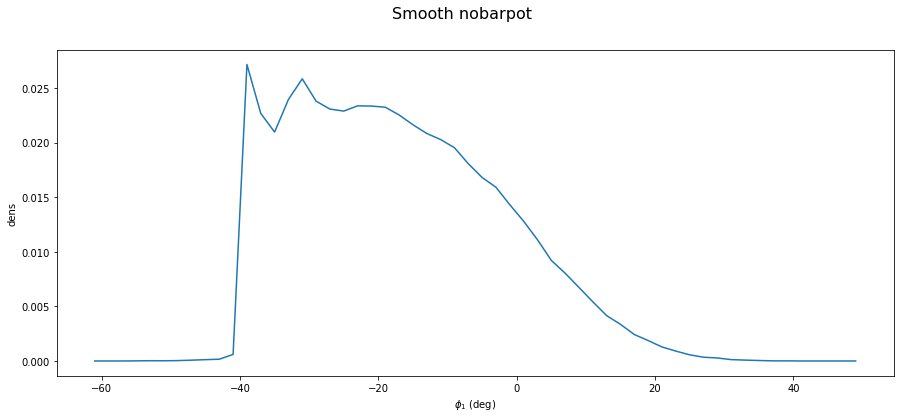

In [6]:
#smooth stream, 

#R   phi   z   vR    vT    vz

Rs,phis,zs,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/spraydf_sample_100K_nobarpot_final_coord.dat",unpack=True)
   
p1s,p2s=galcencyl_to_phi12(Rs,phis,zs)

#midphi1s,Ndns,Ndns_err,ndens,ndens_err,dens,pps = compute_ndenphi1(p1s,maxphi1=-4.,minphi1=-34.,bw=2)

midphi1s,dens=bin_full_stream(p1s)

    

plt.figure(figsize=(15,6))
plt.suptitle("Smooth nobarpot",fontsize=16)
#plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1s,dens)
plt.ylabel("dens")
plt.xlabel(r'$\phi_{1}$ (deg)')

#plt.subplot(1,2,2)
#plt.plot(midphi1s,ndens) 
#plt.errorbar(midphi1s,ndens,ndens_err)
#plt.plot(outphi1,dens_cont,label="")
#plt.ylabel('normalized density')
#plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

### only strong bar+spiral; initial sample generated in nobarpot

min/max phi1 : -53.18377818088294 43.208210082699146
bin edges : [-62. -60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40. -38. -36.
 -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.
  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.
  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.
  50.]
100000


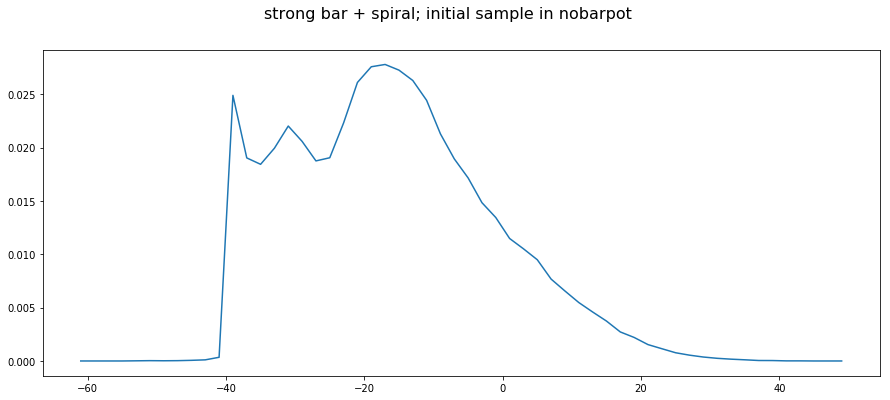

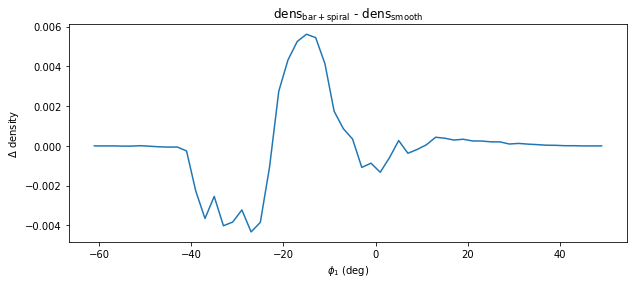

In [7]:
#only strong bar+spiral; initial sample generated in nobarpot

#R   phi   z   vR    vT    vz
R_nobarpot_strongBS=[]
phi_nobarpot_strongBS=[]
z_nobarpot_strongBS=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/nobarpot_init_strongbarpot_final/spraydf_sample_nobarpot_init_strongbarpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_nobarpot_strongBS.append(R[jj])
        phi_nobarpot_strongBS.append(phi[jj])
        z_nobarpot_strongBS.append(z[jj])
    
    
p1_nobarpot_strongBS,p2_nobarpot_strongBS=galcencyl_to_phi12(R_nobarpot_strongBS,phi_nobarpot_strongBS,z_nobarpot_strongBS)

#midphi1_nobarpot_strongBS,Ndn_nobarpot_strongBS,Ndn_nobarpot_strongBSerr,nden_nobarpot_strongBS,nden_nobarpot_strongBSerr,den_nobarpot_strongBS,pp_nobarpot_strongBS = compute_ndenphi1(p1_nobarpot_strongBS,maxphi1=-4.,minphi1=-34.,bw=2)
midphi1_nobarpot_strongBS,den_nobarpot_strongBS  = bin_full_stream(p1_nobarpot_strongBS)

plt.figure(figsize=(15,6))
plt.suptitle("strong bar + spiral; initial sample in nobarpot",fontsize=16)
#plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_nobarpot_strongBS,den_nobarpot_strongBS)

#plt.subplot(1,2,2)
#plt.plot(midphi1_nobarpot_strongBS,nden_nobarpot_strongBS) 
#plt.errorbar(midphi1_nobarpot_strongBS,nden_nobarpot_strongBS,nden_nobarpot_strongBSerr)
#plt.plot(outphi1,dens_cont,label="")
#plt.ylabel('normalized density')
#plt.xlabel(r'$\phi_{1}$ (deg)')

#plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{bar + spiral}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_nobarpot_strongBS,den_nobarpot_strongBS - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



### only subhalos with timescdm = 0.5, initial sample generated in nobarpot

min/max phi1 : -52.81380246780628 40.832205341554115
bin edges : [-62. -60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40. -38. -36.
 -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.
  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.
  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.
  50.]
100000


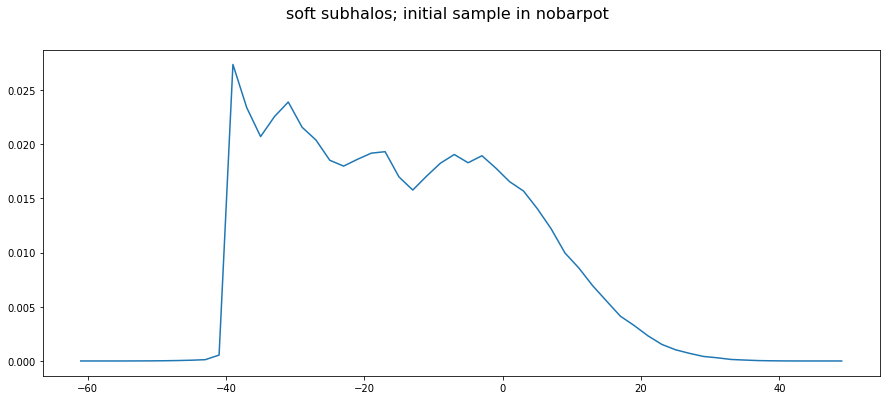

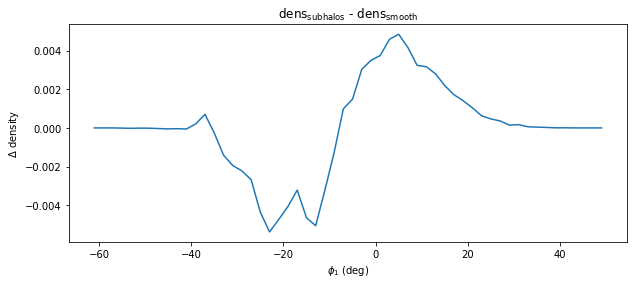

In [8]:
#only subhalos with timescdm = 0.5, initial sample generated in nobarpot

#R   phi   z   vR    vT    vz
R_sub_nobarpot=[]
phi_sub_nobarpot=[]
z_sub_nobarpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/nobarpot_init_softsubhalos_nobarpot_final/spraydf_sample_nobarpot_init_softsubhalos_nobarpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_sub_nobarpot.append(R[jj])
        phi_sub_nobarpot.append(phi[jj])
        z_sub_nobarpot.append(z[jj])
    
    
p1_sub_nobarpot,p2_sub_nobarpot=galcencyl_to_phi12(R_sub_nobarpot,phi_sub_nobarpot,z_sub_nobarpot)

#midphi1_sub_nobarpot,Ndn_sub_nobarpot,Ndn_sub_nobarpoterr,nden_sub_nobarpot,nden_sub_nobarpoterr,den_sub_nobarpot,pp_sub_nobarpot = compute_ndenphi1(p1_sub_nobarpot,
#                                                                                                              maxphi1=-4.,
#                                                                                                             minphi1=-34.,bw=2)

midphi1_sub_nobarpot,den_sub_nobarpot = bin_full_stream(p1_sub_nobarpot)

plt.figure(figsize=(15,6))
plt.suptitle("soft subhalos; initial sample in nobarpot",fontsize=16)
#plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_sub_nobarpot,den_sub_nobarpot)

#plt.subplot(1,2,2)
#plt.plot(midphi1_sub_nobarpot,nden_sub_nobarpot) 
#plt.errorbar(midphi1_sub_nobarpot,nden_sub_nobarpot,nden_sub_nobarpoterr)
#plt.plot(outphi1,dens_cont,label="")
#plt.ylabel('normalized density')
#plt.xlabel(r'$\phi_{1}$ (deg)')

#plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{subhalos}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_sub_nobarpot,den_sub_nobarpot - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



### subhalos + strong bar+spiral; initial sample generated in nobarpot

min/max phi1 : -52.60255621803009 44.77966858356572
bin edges : [-62. -60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40. -38. -36.
 -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.
  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.
  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.
  50.]
100000


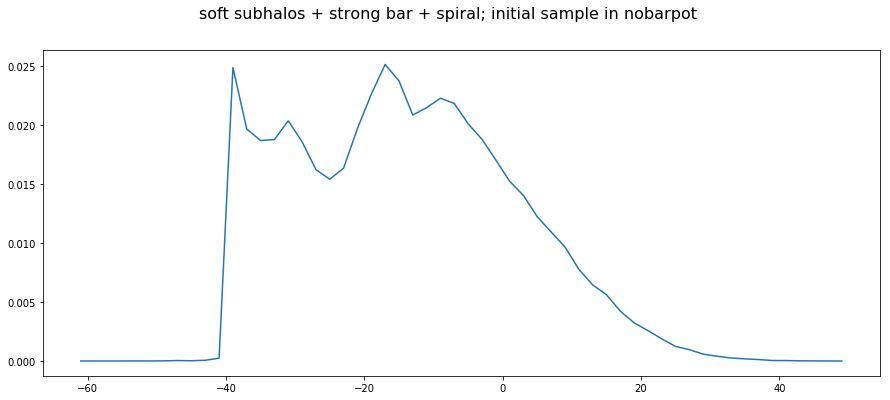

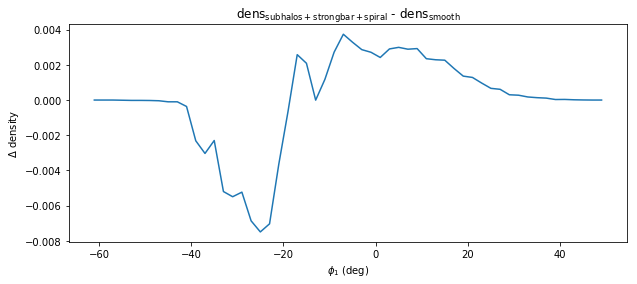

In [9]:
#subhalos + bar + strong spiral, initial sample generated in nobarpot

#R   phi   z   vR    vT    vz
R_substrongBS_nobarpot=[]
phi_substrongBS_nobarpot=[]
z_substrongBS_nobarpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/nobarpot_init_softsubhalos_strongbarpot_final/spraydf_sample_nobarpot_init_softsubhalos_strongbarpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_substrongBS_nobarpot.append(R[jj])
        phi_substrongBS_nobarpot.append(phi[jj])
        z_substrongBS_nobarpot.append(z[jj])
    
    
p1_substrongBS_nobarpot,p2_substrongBS_nobarpot=galcencyl_to_phi12(R_substrongBS_nobarpot,phi_substrongBS_nobarpot,z_substrongBS_nobarpot)

#midphi1_substrongBS_nobarpot,Ndn_substrongBS_nobarpot,Ndn_substrongBS_nobarpoterr,nden_substrongBS_nobarpot,nden_substrongBS_nobarpoterr,den_substrongBS_nobarpot,pp_substrongBS_nobarpot = compute_ndenphi1(p1_substrongBS_nobarpot,
#                                                                                                              maxphi1=-4.,
#                                                                                                             minphi1=-34.,bw=2)


midphi1_substrongBS_nobarpot,den_substrongBS_nobarpot = bin_full_stream(p1_substrongBS_nobarpot)
plt.figure(figsize=(15,6))
plt.suptitle("soft subhalos + strong bar + spiral; initial sample in nobarpot",fontsize=16)
#plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_substrongBS_nobarpot,den_substrongBS_nobarpot)

#plt.subplot(1,2,2)
#plt.plot(midphi1_substrongBS_nobarpot,nden_substrongBS_nobarpot) 
#plt.errorbar(midphi1_substrongBS_nobarpot,nden_substrongBS_nobarpot,nden_substrongBS_nobarpoterr)
#plt.plot(outphi1,dens_cont,label="")
#plt.ylabel('normalized density')
#plt.xlabel(r'$\phi_{1}$ (deg)')

#plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{subhalos + strong bar + spiral}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_substrongBS_nobarpot,den_substrongBS_nobarpot - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



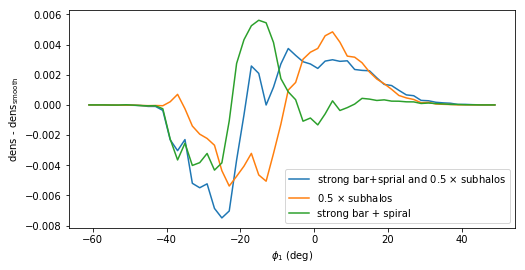

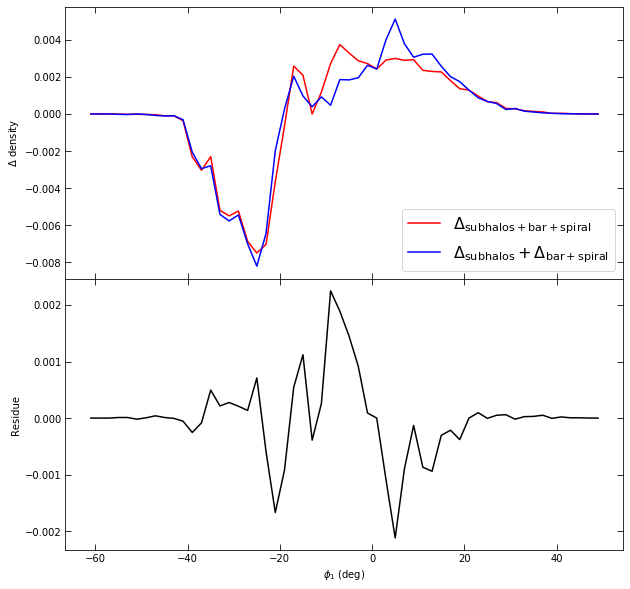

In [10]:
#delta dens_(sub+bar/spiral) ==? delta dens_(no-sub+bar/spiral) + delta dens_(sub+nobar/spiral)
#initial sample in nobarpot

plt.figure(figsize=(8,4))
plt.plot(midphi1_substrongBS_nobarpot,den_substrongBS_nobarpot - dens,label=r"strong bar+sprial and 0.5 $\times$ subhalos")
plt.plot(midphi1_sub_nobarpot,den_sub_nobarpot - dens,label=r"0.5 $\times$ subhalos")
plt.plot(midphi1_nobarpot_strongBS,den_nobarpot_strongBS - dens,label="strong bar + spiral")
plt.ylabel(r"dens - dens$_{\mathrm{smooth}}$")
plt.legend(loc='lower right')
plt.xlabel(r"$\phi_{1}$ (deg)")
plt.show()


plt.figure(figsize=(10,10))
ax1=plt.subplot(2,1,1)

ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(midphi1_substrongBS_nobarpot,den_substrongBS_nobarpot - dens,c='r',label=r'$\Delta_{\rm{subhalos + bar + spiral}}$')
plt.plot(midphi1_substrongBS_nobarpot,((den_sub_nobarpot - dens) + (den_nobarpot_strongBS - dens)),c='b',label=r'$\Delta_{\rm{subhalos}} + \Delta_{\rm{bar + spiral}}$')
plt.ylabel(r'$\Delta$ density')
#plt.xlim(220.,250.)
#plt.ylim(-5.,9.)
#plt.xlabel('RA (deg)')
#plt.text(0.03,0.85,'Frequency-angle',fontsize=16,transform=ax1.transAxes)
#plt.xlabel([])
plt.legend(loc='lower right',fontsize=16)
plt.xtick_labelsize=0.

ax2=plt.subplot(2,1,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(midphi1_substrongBS_nobarpot,(den_substrongBS_nobarpot - dens) - ((den_sub_nobarpot - dens) + (den_nobarpot_strongBS - dens)),c='k')

plt.ylabel(r'Residue')
plt.xlabel(r'$\phi_{1}$ (deg)')
#plt.xlabel('RA (deg)',fontsize=16)
#plt.ylabel('Dec (deg)',fontsize=16)
#plt.legend(loc='lower right',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/streamdf_spraydf_compare.pdf',bbox_inches='tight')
plt.show()



### Repeat above steps for Pal 5

In [ ]:
#remake spiral+bar potential since the age of the stream is 5 Gyrs now

#n=9, l=19
Ac,As=SCFbar_util_new.compute_Acos_Asin()

barpot,nobarpot=SCFbar_util_new.MWPotentialSCFbar_grow(mbar=10.**10.,Acos=Ac,Asin=As,pat_speed=39.,fin_phi_deg=27.,t_on=-5.,tgrow=2,tstream=5.)

spiral_pot=spiralarms_util.spiral_only_potential(tstream=5.,axi_pot=nobarpot,N=4,Rs=3.)

MW_bar_spiral_pot=barpot+[spiral_pot]
turn_physical_off(MW_bar_spiral_pot)


orb=[229.018,-0.124,23.2,-2.296,-2.257,-58.7]
                      
o= Orbit(orb,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])

#convert to galpy units
orb=Orbit(o._orb.vxvv)


Nsamples=100000
spdft= streamspraydf.streamspraydf(10000*u.Msun,progenitor=orb,pot=nobarpot,leading=False,tdisrupt=5.*u.Gyr)
RvR,dt= spdft.sample(n=Nsamples,returndt=True,integrate=False)
R=RvR[0]
vR=RvR[1]
vT=RvR[2]
z=RvR[3]
vz=RvR[4]
phi=RvR[5]

fo=open("Pal5_spraydf_sample_100K_nobarpot_initial_coord.dat","w")
fo.write("#R   phi   z   vR    vT    vz    ts" + "\n")

for jj in range(Nsamples):
    fo.write(str(R[jj]) + "   " + str(phi[jj]) + "   " + str(z[jj]) + "   " + str(vR[jj]) + "   " + str(vT[jj]) + "   " + str(vz[jj]) + "   " + str(dt[jj]) + "\n")

fo.close()


Integrate the points upto today in the nobarpot

In [ ]:
fo1=open("Pal5_spraydf_sample_100K_nobarpot_final_coord.dat","w")
fo1.write("#R   phi   z   vR    vT    vz    ts" + "\n")

for ii in range(100000):
    ts=np.linspace(-dt[ii],0,1001)
    o=Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]])
    o.integrate(ts,nobarpot)
    fo1.write(str(o.R(ts[-1])) + "   " + str(o.phi(ts[-1])) + "   " + str(o.z(ts[-1])) + "   " + str(o.vR(ts[-1])) + "   " + str(o.vT(ts[-1])) + "   " + str(o.vz(ts[-1])) + "\n")
        
fo1.close() 

In [11]:
#load the impacted sdf_pepper file

import pal5_util

with open('pal5_pklfiles/pal5_smooth_pepper_td5.0_64sampling_MW2014.pkl','rb') as savefile:
            sdf_pepper_imp= pickle.load(savefile,encoding='latin1')

sdf_smooth= pal5_util.setup_pal5model()

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)

def galcencyl_to_xieta(R,phi,Z,degree=True):
    l,b,d=np.array(galcencyl_to_lbd(R,phi,Z))
    radec=bovy_coords.lb_to_radec(l,b,degree=True) 
    mxieta=pal5_util.radec_to_pal5xieta(radec[:,0],radec[:,1],degree=True)
    xi= mxieta[:,0]
    eta=mxieta[:,1]
    return (xi,eta)


def bin_full_stream(xi,nbin=10):
    
    bins_edge=np.linspace(-8,91,60) #these bin bounds enclose all points in all cases
    bw=bins_edge[1]-bins_edge[0]
    print ("min/max xi :",min(xi),max(xi))
    print ("bin edges :",bins_edge)

    midxi=[0.5*(bins_edge[i] + bins_edge[i+1]) for i in range(len(bins_edge)-1)]
    Ndn=np.histogram(xi,bins_edge)[0]
    den=Ndn/(np.sum(Ndn)*bw)
    print (np.sum(Ndn))
    return (midxi,den)

min/max xi : -4.443992466815465 40.672520135041985
bin edges : [-8.         -6.3220339  -4.6440678  -2.96610169 -1.28813559  0.38983051
  2.06779661  3.74576271  5.42372881  7.10169492  8.77966102 10.45762712
 12.13559322 13.81355932 15.49152542 17.16949153 18.84745763 20.52542373
 22.20338983 23.88135593 25.55932203 27.23728814 28.91525424 30.59322034
 32.27118644 33.94915254 35.62711864 37.30508475 38.98305085 40.66101695
 42.33898305 44.01694915 45.69491525 47.37288136 49.05084746 50.72881356
 52.40677966 54.08474576 55.76271186 57.44067797 59.11864407 60.79661017
 62.47457627 64.15254237 65.83050847 67.50847458 69.18644068 70.86440678
 72.54237288 74.22033898 75.89830508 77.57627119 79.25423729 80.93220339
 82.61016949 84.28813559 85.96610169 87.6440678  89.3220339  91.        ]
100000


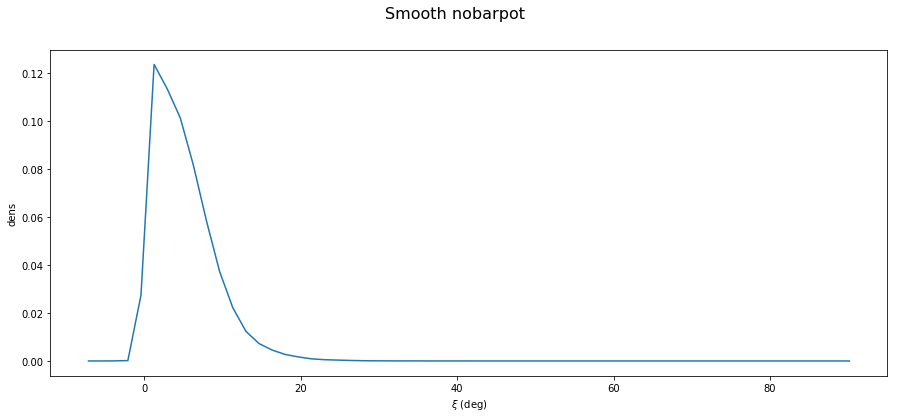

In [12]:
#smooth stream, 

#R   phi   z   vR    vT    vz

Rs,phis,zs,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/Pal5_spraydf_sample_100K_nobarpot_final_coord.dat",unpack=True)
   
xis,etas=galcencyl_to_xieta(Rs,phis,zs)

midxis,dens=bin_full_stream(xis)
   

plt.figure(figsize=(15,6))
plt.suptitle("Smooth nobarpot",fontsize=16)
#plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midxis,dens)
plt.ylabel("dens")
plt.xlabel(r'$\xi$ (deg)')

plt.show()

min/max xi : -5.189154645266798 43.58201381951184
bin edges : [-8.         -6.3220339  -4.6440678  -2.96610169 -1.28813559  0.38983051
  2.06779661  3.74576271  5.42372881  7.10169492  8.77966102 10.45762712
 12.13559322 13.81355932 15.49152542 17.16949153 18.84745763 20.52542373
 22.20338983 23.88135593 25.55932203 27.23728814 28.91525424 30.59322034
 32.27118644 33.94915254 35.62711864 37.30508475 38.98305085 40.66101695
 42.33898305 44.01694915 45.69491525 47.37288136 49.05084746 50.72881356
 52.40677966 54.08474576 55.76271186 57.44067797 59.11864407 60.79661017
 62.47457627 64.15254237 65.83050847 67.50847458 69.18644068 70.86440678
 72.54237288 74.22033898 75.89830508 77.57627119 79.25423729 80.93220339
 82.61016949 84.28813559 85.96610169 87.6440678  89.3220339  91.        ]
100000


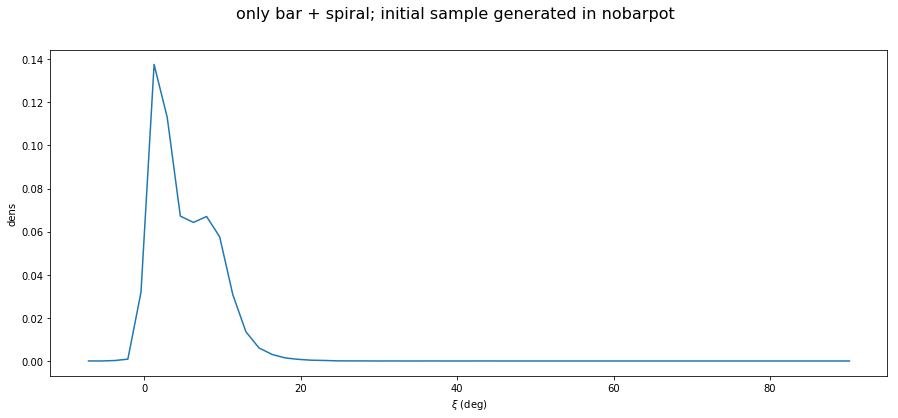

In [13]:
#R   phi   z   vR    vT    vz
R_BS=[]
phi_BS=[]
z_BS=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/Pal5_nobarpot_init_barpot_final/Pal5_spraydf_sample_nobarpot_init_barpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_BS.append(R[jj])
        phi_BS.append(phi[jj])
        z_BS.append(z[jj])
        
xi_BS,eta_BS=galcencyl_to_xieta(R_BS,phi_BS,z_BS)

midxi_BS,dens_BS=bin_full_stream(xi_BS)
   

plt.figure(figsize=(15,6))
plt.suptitle("only bar + spiral; initial sample generated in nobarpot",fontsize=16)
#plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midxi_BS,dens_BS)
plt.ylabel("dens")
plt.xlabel(r'$\xi$ (deg)')

plt.show()

min/max xi : -6.2572123812939004 90.4869795329345
bin edges : [-8.         -6.3220339  -4.6440678  -2.96610169 -1.28813559  0.38983051
  2.06779661  3.74576271  5.42372881  7.10169492  8.77966102 10.45762712
 12.13559322 13.81355932 15.49152542 17.16949153 18.84745763 20.52542373
 22.20338983 23.88135593 25.55932203 27.23728814 28.91525424 30.59322034
 32.27118644 33.94915254 35.62711864 37.30508475 38.98305085 40.66101695
 42.33898305 44.01694915 45.69491525 47.37288136 49.05084746 50.72881356
 52.40677966 54.08474576 55.76271186 57.44067797 59.11864407 60.79661017
 62.47457627 64.15254237 65.83050847 67.50847458 69.18644068 70.86440678
 72.54237288 74.22033898 75.89830508 77.57627119 79.25423729 80.93220339
 82.61016949 84.28813559 85.96610169 87.6440678  89.3220339  91.        ]
100000


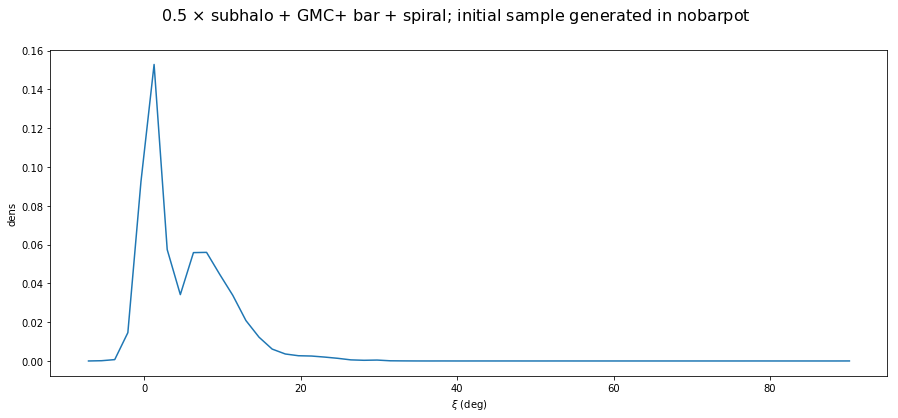

In [16]:
R_subGMC_barpot=[]
phi_subGMC_barpot=[]
z_subGMC_barpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/Pal5_nobarpot_init_softsubhalos_GMC_barpot_final/Pal5_spraydf_sample_nobarpot_init_softsubhalos_GMC_barpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_subGMC_barpot.append(R[jj])
        phi_subGMC_barpot.append(phi[jj])
        z_subGMC_barpot.append(z[jj])
        
xi_subGMC_barpot,eta_subGMC_barpot=galcencyl_to_xieta(R_subGMC_barpot,phi_subGMC_barpot,z_subGMC_barpot)

midxi_subGMC_barpot,dens_subGMC_barpot=bin_full_stream(xi_subGMC_barpot)
   
plt.figure(figsize=(15,6))
plt.suptitle(r"0.5 $\times$ subhalo + GMC+ bar + spiral; initial sample generated in nobarpot",fontsize=16)
#plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midxi_subGMC_barpot,dens_subGMC_barpot)
plt.ylabel("dens")
plt.xlabel(r'$\xi$ (deg)')

plt.show()

min/max xi : -5.636305126678533 69.87275241010988
bin edges : [-8.         -6.3220339  -4.6440678  -2.96610169 -1.28813559  0.38983051
  2.06779661  3.74576271  5.42372881  7.10169492  8.77966102 10.45762712
 12.13559322 13.81355932 15.49152542 17.16949153 18.84745763 20.52542373
 22.20338983 23.88135593 25.55932203 27.23728814 28.91525424 30.59322034
 32.27118644 33.94915254 35.62711864 37.30508475 38.98305085 40.66101695
 42.33898305 44.01694915 45.69491525 47.37288136 49.05084746 50.72881356
 52.40677966 54.08474576 55.76271186 57.44067797 59.11864407 60.79661017
 62.47457627 64.15254237 65.83050847 67.50847458 69.18644068 70.86440678
 72.54237288 74.22033898 75.89830508 77.57627119 79.25423729 80.93220339
 82.61016949 84.28813559 85.96610169 87.6440678  89.3220339  91.        ]
100000


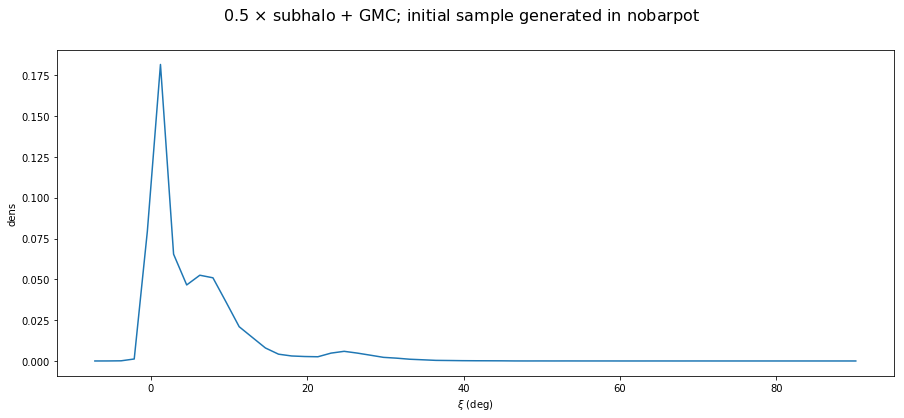

In [17]:
R_subGMC_nobarpot=[]
phi_subGMC_nobarpot=[]
z_subGMC_nobarpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/Pal5_nobarpot_init_softsubhalos_GMC_nobarpot_final/Pal5_spraydf_sample_nobarpot_init_softsubhalos_GMC_nobarpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_subGMC_nobarpot.append(R[jj])
        phi_subGMC_nobarpot.append(phi[jj])
        z_subGMC_nobarpot.append(z[jj])
        
xi_subGMC_nobarpot,eta_subGMC_nobarpot=galcencyl_to_xieta(R_subGMC_nobarpot,phi_subGMC_nobarpot,z_subGMC_nobarpot)

midxi_subGMC_nobarpot,dens_subGMC_nobarpot=bin_full_stream(xi_subGMC_nobarpot)
   
plt.figure(figsize=(15,6))
plt.suptitle(r"0.5 $\times$ subhalo + GMC; initial sample generated in nobarpot",fontsize=16)
#plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midxi_subGMC_nobarpot,dens_subGMC_nobarpot)
plt.ylabel("dens")
plt.xlabel(r'$\xi$ (deg)')

plt.show()

### 0.5 x subhalos + GMC + GC and bar + spiral

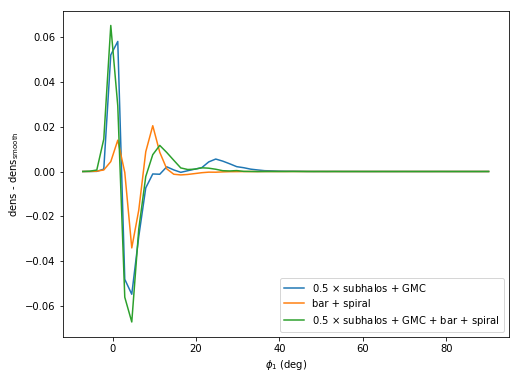

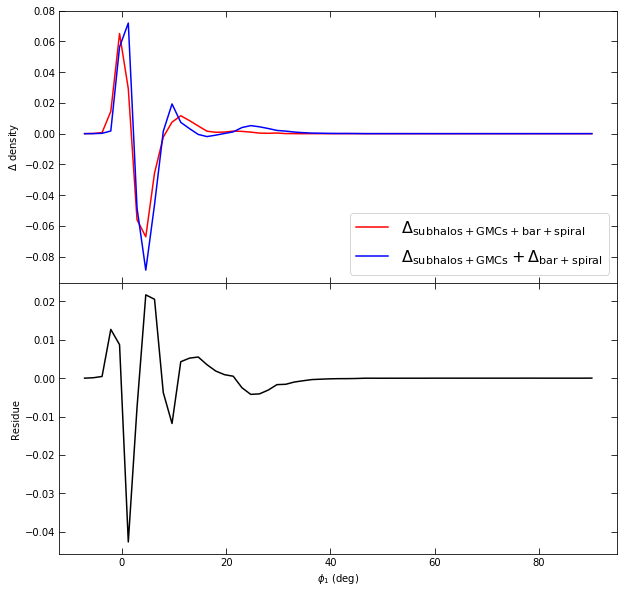

In [18]:
plt.figure(figsize=(8,6))
plt.plot(midxis,dens_subGMC_nobarpot - dens,label=r"0.5 $\times$ subhalos + GMC")
plt.plot(midxis,dens_BS - dens,label=r"bar + spiral")
plt.plot(midxis,dens_subGMC_barpot - dens,label=r"0.5 $\times$ subhalos + GMC + bar + spiral")
plt.ylabel(r"dens - dens$_{\mathrm{smooth}}$")
plt.legend(loc='lower right')
plt.xlabel(r"$\phi_{1}$ (deg)")
plt.show()




plt.figure(figsize=(10,10))
ax1=plt.subplot(2,1,1)

ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(midxis,dens_subGMC_barpot - dens,c='r',label=r'$\Delta_{\rm{subhalos + GMCs + bar + spiral}}$')
plt.plot(midxis,((dens_subGMC_nobarpot - dens) + (dens_BS - dens)),c='b',label=r'$\Delta_{\rm{subhalos + GMCs}} + \Delta_{\rm{bar + spiral}}$')
plt.ylabel(r'$\Delta$ density')
#plt.xlim(220.,250.)
#plt.ylim(-5.,9.)
#plt.xlabel('RA (deg)')
#plt.text(0.03,0.85,'Frequency-angle',fontsize=16,transform=ax1.transAxes)
#plt.xlabel([])
plt.legend(loc='lower right',fontsize=16)
plt.xtick_labelsize=0.

ax2=plt.subplot(2,1,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(midxis,(dens_subGMC_barpot - dens) - ((dens_subGMC_nobarpot - dens) + (dens_BS - dens)),c='k')

plt.ylabel(r'Residue')
plt.xlabel(r'$\phi_{1}$ (deg)')
#plt.xlabel('RA (deg)',fontsize=16)
#plt.ylabel('Dec (deg)',fontsize=16)
#plt.legend(loc='lower right',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/streamdf_spraydf_compare.pdf',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
ax1=plt.subplot(2,1,1)

ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(midxis,dens_subGMC_barpot - dens,c='r',label=r'$\Delta_{\rm{subhalos + bar + spiral}}$')
plt.plot(midxis,((dens_subGMC_barpot - dens) + (dens_BS - dens)),c='b',label=r'$\Delta_{\rm{subhalos}} + \Delta_{\rm{bar + spiral}}$')
plt.ylabel(r'$\Delta$ density')
#plt.xlim(220.,250.)
#plt.ylim(-5.,9.)
#plt.xlabel('RA (deg)')
#plt.text(0.03,0.85,'Frequency-angle',fontsize=16,transform=ax1.transAxes)
#plt.xlabel([])
plt.legend(loc='lower right',fontsize=16)
plt.xtick_labelsize=0.

ax2=plt.subplot(2,1,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(midxis,(dens_sub_barpot - dens) - ((dens_sub_barpot - dens) + (dens_BS - dens)),c='k')

plt.ylabel(r'Residue')
plt.xlabel(r'$\phi_{1}$ (deg)')
#plt.xlabel('RA (deg)',fontsize=16)
#plt.ylabel('Dec (deg)',fontsize=16)
#plt.legend(loc='lower right',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/streamdf_spraydf_compare.pdf',bbox_inches='tight')
plt.show()

In [ ]:
#only bar+spiral; initial sample generated in nobarpot

#R   phi   z   vR    vT    vz
R_nobarpot_BS=[]
phi_nobarpot_BS=[]
z_nobarpot_BS=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/nobarpot_init_barpot_final/spraydf_sample_nobar_init_barpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_nobarpot_BS.append(R[jj])
        phi_nobarpot_BS.append(phi[jj])
        z_nobarpot_BS.append(z[jj])
    
    
p1_nobarpot_BS,p2_nobarpot_BS=galcencyl_to_phi12(R_nobarpot_BS,phi_nobarpot_BS,z_nobarpot_BS)

midphi1_nobarpot_BS,Ndn_nobarpot_BS,Ndn_nobarpot_BSerr,nden_nobarpot_BS,nden_nobarpot_BSerr,den_nobarpot_BS,pp_nobarpot_BS = compute_ndenphi1(p1_nobarpot_BS,maxphi1=-4.,minphi1=-34.,bw=2)

plt.figure(figsize=(15,6))
plt.suptitle("bar + spiral; initial sample in nobarpot",fontsize=16)
plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_nobarpot_BS,den_nobarpot_BS)

plt.subplot(1,2,2)
plt.plot(midphi1_nobarpot_BS,nden_nobarpot_BS) 
plt.errorbar(midphi1_nobarpot_BS,nden_nobarpot_BS,nden_nobarpot_BSerr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{bar + spiral}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_nobarpot_BS,den_nobarpot_BS - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



In [ ]:
#only subhalos, initial sample generated in nobarpot

#R   phi   z   vR    vT    vz
R_sub_nobarpot=[]
phi_sub_nobarpot=[]
z_sub_nobarpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/nobarpot_init_subhalos_nobarpot_final/spraydf_sample_nobarpot_init_subhalos_nobarpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_sub_nobarpot.append(R[jj])
        phi_sub_nobarpot.append(phi[jj])
        z_sub_nobarpot.append(z[jj])
    
    
p1_sub_nobarpot,p2_sub_nobarpot=galcencyl_to_phi12(R_sub_nobarpot,phi_sub_nobarpot,z_sub_nobarpot)

midphi1_sub_nobarpot,Ndn_sub_nobarpot,Ndn_sub_nobarpoterr,nden_sub_nobarpot,nden_sub_nobarpoterr,den_sub_nobarpot,pp_sub_nobarpot = compute_ndenphi1(p1_sub_nobarpot,
                                                                                                              maxphi1=-4.,
                                                                                                             minphi1=-34.,bw=2)

plt.figure(figsize=(15,6))
plt.suptitle("subhalos; initial sample in nobarpot",fontsize=16)
plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_sub_nobarpot,den_sub_nobarpot)

plt.subplot(1,2,2)
plt.plot(midphi1_sub_nobarpot,nden_sub_nobarpot) 
plt.errorbar(midphi1_sub_nobarpot,nden_sub_nobarpot,nden_sub_nobarpoterr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{subhalos}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_sub_nobarpot,den_sub_nobarpot - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



In [ ]:
#only bar+spiral; initial sample generated in barpot

#R   phi   z   vR    vT    vz
R_BS=[]
phi_BS=[]
z_BS=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/barpot_init_barpot_final/spraydf_sample_barpot_init_barpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_BS.append(R[jj])
        phi_BS.append(phi[jj])
        z_BS.append(z[jj])
    
    
p1_BS,p2_BS=galcencyl_to_phi12(R_BS,phi_BS,z_BS)

midphi1_BS,Ndn_BS,Ndn_BSerr,nden_BS,nden_BSerr,den_BS,pp_BS = compute_ndenphi1(p1_BS,maxphi1=-4.,minphi1=-34.,bw=2)

plt.figure(figsize=(15,6))
plt.suptitle("bar + spiral; initial sample in barpot",fontsize=16)
plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_BS,den_BS)

plt.subplot(1,2,2)
plt.plot(midphi1_BS,nden_BS) 
plt.errorbar(midphi1_BS,nden_BS,nden_BSerr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{bar + spiral}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_BS,den_BS - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



In [ ]:
#only subhalos, initial sample generated in barpot

#R   phi   z   vR    vT    vz
R_sub_barpot=[]
phi_sub_barpot=[]
z_sub_barpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/barpot_init_subhalos_nobarpot_final/spraydf_sample_barpot_init_subhalos_nobarpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_sub_barpot.append(R[jj])
        phi_sub_barpot.append(phi[jj])
        z_sub_barpot.append(z[jj])
    
    
p1_sub_barpot,p2_sub_barpot=galcencyl_to_phi12(R_sub_barpot,phi_sub_barpot,z_sub_barpot)

midphi1_sub_barpot,Ndn_sub_barpot,Ndn_sub_barpoterr,nden_sub_barpot,nden_sub_barpoterr,den_sub_barpot,pp_sub_barpot = compute_ndenphi1(p1_sub_barpot,
                                                                                                              maxphi1=-4.,
                                                                                                             minphi1=-34.,bw=2)

plt.figure(figsize=(15,6))
plt.suptitle("subhalos; initial sample in barpot",fontsize=16)
plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_sub_barpot,den_sub_barpot)

plt.subplot(1,2,2)
plt.plot(midphi1_sub_barpot,nden_sub_barpot) 
plt.errorbar(midphi1_sub_barpot,nden_sub_barpot,nden_sub_barpoterr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{subhalos}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_sub_barpot,den_sub_barpot - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



In [ ]:
#subhalos + bar + spiral, initial sample generated in barpot

#R   phi   z   vR    vT    vz
R_subBS_barpot=[]
phi_subBS_barpot=[]
z_subBS_barpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/barpot_init_subhalos_barpot_final/spraydf_sample_barpot_init_subhalos_barpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_subBS_barpot.append(R[jj])
        phi_subBS_barpot.append(phi[jj])
        z_subBS_barpot.append(z[jj])
    
    
p1_subBS_barpot,p2_subBS_barpot=galcencyl_to_phi12(R_subBS_barpot,phi_subBS_barpot,z_subBS_barpot)

midphi1_subBS_barpot,Ndn_subBS_barpot,Ndn_subBS_barpoterr,nden_subBS_barpot,nden_subBS_barpoterr,den_subBS_barpot,pp_subBS_barpot = compute_ndenphi1(p1_subBS_barpot,
                                                                                                              maxphi1=-4.,
                                                                                                             minphi1=-34.,bw=2)

plt.figure(figsize=(15,6))
plt.suptitle("subhalos + bar + spiral; initial sample in barpot",fontsize=16)
plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_subBS_barpot,den_subBS_barpot)

plt.subplot(1,2,2)
plt.plot(midphi1_subBS_barpot,nden_subBS_barpot) 
plt.errorbar(midphi1_subBS_barpot,nden_subBS_barpot,nden_subBS_barpoterr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{subhalos + bar + spiral}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_subBS_barpot,den_subBS_barpot - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



In [ ]:
#subhalos + bar + spiral, initial sample generated in nobarpot

#R   phi   z   vR    vT    vz
R_subBS_nobarpot=[]
phi_subBS_nobarpot=[]
z_subBS_nobarpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/nobarpot_init_subhalos_barpot_final/spraydf_sample_nobarpot_init_subhalos_barpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_subBS_nobarpot.append(R[jj])
        phi_subBS_nobarpot.append(phi[jj])
        z_subBS_nobarpot.append(z[jj])
    
    
p1_subBS_nobarpot,p2_subBS_nobarpot=galcencyl_to_phi12(R_subBS_nobarpot,phi_subBS_nobarpot,z_subBS_nobarpot)

midphi1_subBS_nobarpot,Ndn_subBS_nobarpot,Ndn_subBS_nobarpoterr,nden_subBS_nobarpot,nden_subBS_nobarpoterr,den_subBS_nobarpot,pp_subBS_nobarpot = compute_ndenphi1(p1_subBS_nobarpot,
                                                                                                              maxphi1=-4.,
                                                                                                             minphi1=-34.,bw=2)

plt.figure(figsize=(15,6))
plt.suptitle("subhalos + bar + spiral; initial sample in barpot",fontsize=16)
plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_subBS_nobarpot,den_subBS_nobarpot)

plt.subplot(1,2,2)
plt.plot(midphi1_subBS_nobarpot,nden_subBS_nobarpot) 
plt.errorbar(midphi1_subBS_nobarpot,nden_subBS_nobarpot,nden_subBS_nobarpoterr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

plt.figure(figsize=(10,4))
plt.title(r"dens$_{\rm{subhalos + bar + spiral}}$ - dens$_{\rm{smooth}}$")
plt.plot(midphi1_subBS_nobarpot,den_subBS_nobarpot - dens)
plt.ylabel(r'$\Delta$ density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()



In [ ]:
#delta dens_(sub+bar/spiral) ==? delta dens_(no-sub+bar/spiral) + delta dens_(sub+nobar/spiral)


plt.figure(figsize=(10,10))
ax1=plt.subplot(2,1,1)

ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(midphi1_subBS_barpot,den_subBS_barpot - dens,c='r',label=r'$\Delta_{\rm{subhalos + bar + spiral}}$')
plt.plot(midphi1_subBS_barpot,((den_sub_nobarpot - dens) + (den_BS - dens)),c='b',label=r'$\Delta_{\rm{subhalos}} + \Delta_{\rm{bar + spiral}}$')
plt.ylabel(r'$\Delta$ density')
#plt.xlim(220.,250.)
#plt.ylim(-5.,9.)
#plt.xlabel('RA (deg)')
#plt.text(0.03,0.85,'Frequency-angle',fontsize=16,transform=ax1.transAxes)
#plt.xlabel([])
plt.legend(loc='upper right',fontsize=16)
plt.xtick_labelsize=0.

ax2=plt.subplot(2,1,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(midphi1_subBS_barpot,(den_subBS_barpot - dens) - ((den_sub_nobarpot - dens) + (den_BS - dens)),c='k')

plt.ylabel(r'Residue')
plt.xlabel(r'$\phi_{1}$ (deg)')
#plt.xlabel('RA (deg)',fontsize=16)
#plt.ylabel('Dec (deg)',fontsize=16)
#plt.legend(loc='lower right',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/streamdf_spraydf_compare.pdf',bbox_inches='tight')
plt.show()



In [ ]:
#delta dens_(sub+bar/spiral) ==? delta dens_(no-sub+bar/spiral) + delta dens_(sub+nobar/spiral)
#initial sample in nobarpot

plt.figure(figsize=(10,10))
ax1=plt.subplot(2,1,1)

ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(midphi1_subBS_barpot,den_subBS_nobarpot - dens,c='r',label=r'$\Delta_{\rm{subhalos + bar + spiral}}$')
plt.plot(midphi1_subBS_barpot,((den_sub_nobarpot - dens) + (den_nobarpot_BS - dens)),c='b',label=r'$\Delta_{\rm{subhalos}} + \Delta_{\rm{bar + spiral}}$')
plt.ylabel(r'$\Delta$ density')
#plt.xlim(220.,250.)
#plt.ylim(-5.,9.)
#plt.xlabel('RA (deg)')
#plt.text(0.03,0.85,'Frequency-angle',fontsize=16,transform=ax1.transAxes)
#plt.xlabel([])
plt.legend(loc='upper right',fontsize=16)
plt.xtick_labelsize=0.

ax2=plt.subplot(2,1,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(midphi1_subBS_barpot,(den_subBS_nobarpot - dens) - ((den_sub_nobarpot - dens) + (den_nobarpot_BS - dens)),c='k')

plt.ylabel(r'Residue')
plt.xlabel(r'$\phi_{1}$ (deg)')
#plt.xlabel('RA (deg)',fontsize=16)
#plt.ylabel('Dec (deg)',fontsize=16)
#plt.legend(loc='lower right',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/streamdf_spraydf_compare.pdf',bbox_inches='tight')
plt.show()



In [ ]:
new_orb_lb=[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]

o=Orbit(new_orb_lb,lb=True,solarmotion=[-11.1,24.,7.25],ro=8.,vo=220.)
#convert to galpy units
orb=Orbit(o._orb.vxvv)


Nsamples=100000
spdft= streamspraydf.streamspraydf(10000*u.Msun,progenitor=orb,pot=MW_bar_spiral_pot,leading=False,tdisrupt=3.2*u.Gyr)
RvR,dt= spdft.sample(n=Nsamples,returndt=True,integrate=False)
R=RvR[0]
vR=RvR[1]
vT=RvR[2]
z=RvR[3]
vz=RvR[4]
phi=RvR[5]

fo=open("spraydf_sample_100K_barpot_initial_coord.dat","w")
fo.write("#R   phi   z   vR    vT    vz    ts" + "\n")

for jj in range(Nsamples):
    fo.write(str(R[jj]) + "   " + str(phi[jj]) + "   " + str(z[jj]) + "   " + str(vR[jj]) + "   " + str(vT[jj]) + "   " + str(vz[jj]) + "   " + str(dt[jj]) + "\n")

fo.close()


Integrate the points upto today in the nobarpot

In [ ]:
fo1=open("spraydf_sample_100K_nobarpot_final_coord.dat","w")
fo1.write("#R   phi   z   vR    vT    vz    ts" + "\n")

for ii in range(100000):
    ts=np.linspace(-dt[ii],0,1001)
    o=Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]])
    o.integrate(ts,nobarpot)
    fo1.write(str(o.R(ts[-1])) + "   " + str(o.phi(ts[-1])) + "   " + str(o.z(ts[-1])) + "   " + str(o.vR(ts[-1])) + "   " + str(o.vT(ts[-1])) + "   " + str(o.vz(ts[-1])) + "\n")
        
fo1.close()    
    

In [ ]:
#R   phi   z   vR    vT    vz
R_nobarpot=[]
phi_nobarpot=[]
z_nobarpot=[]

for ii in range(1000):
    R,phi,z,_,_,_=np.loadtxt("sample_spraydf_subhalos/nobarpot/sample_spraydf_subhalos_N100_nobarpot_GD1stream_trailing_batch{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_nobarpot.append(R[jj])
        phi_nobarpot.append(phi[jj])
        z_nobarpot.append(z[jj])
    
    
p1_nobarpot,p2_nobarpot=galcencyl_to_phi12(R_nobarpot,phi_nobarpot,z_nobarpot)

midphi1_nobarpot,Ndn_nobarpot,Ndn_nobarpoterr,nden_nobarpot,nden_nobarpoterr,den_nobarpot,pp_nobarpot = compute_ndenphi1(p1_nobarpot,
                                                                                                              maxphi1=-4.,
                                                                                                             minphi1=-34.,bw=1)

plt.figure(figsize=(15,6))
plt.suptitle("Subhalos in nobarpot",fontsize=16)
plt.subplot(1,2,1)
#plt.scatter(p1_nobarpot,p2_nobarpot)
plt.plot(midphi1_nobarpot,den_nobarpot)

plt.subplot(1,2,2)
plt.plot(midphi1_nobarpot,nden_nobarpot) 
plt.errorbar(midphi1_nobarpot,nden_nobarpot,nden_nobarpoterr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [ ]:
#R   phi   z   vR    vT    vz
R_BSsub=[]
phi_BSsub=[]
z_BSsub=[]

for ii in range(1000):
    R,phi,z,_,_,_=np.loadtxt("sample_spraydf_subhalos/MWbar+spiral/sample_spraydf_subhalos_N100_MWbar+spiral_GD1stream_trailing_batch{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_BSsub.append(R[jj])
        phi_BSsub.append(phi[jj])
        z_BSsub.append(z[jj])
    
    
p1_BSsub,p2_BSsub=galcencyl_to_phi12(R_BSsub,phi_BSsub,z_BSsub)

midphi1_BSsub,Ndn_BSsub,Ndn_BSsuberr,nden_BSsub,nden_BSsuberr,pp_BSsub = compute_ndenphi1(p1_BSsub,maxphi1=-4., minphi1=-34.,
                                                                                          bw=1)


plt.figure(figsize=(15,6))
plt.suptitle("Subhalos in bar + spiral",fontsize=16)
plt.subplot(1,2,1)
plt.scatter(p1_BSsub,p2_BSsub)

plt.subplot(1,2,2)
plt.plot(midphi1_BSsub,nden_BSsub) 
plt.errorbar(midphi1_BSsub,nden_BSsub,nden_BSsuberr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [ ]:
#R   phi   z   vR    vT    vz
R_BS=[]
phi_BS=[]
z_BS=[]

import glob
#Note: the filename says 50K Msun as the mass of the progenitor, but the mass of the progenitor is 10K Msun, I had forgotten to 
#change the filename 
dir_trail = "sampled_bar_spiral/spraydf_bar_spiral/trailing/"
fname_trail= glob.glob(dir_trail + '*.dat')[0:200]

for ii in fname_trail:
    R,phi,z,_,_,_,_=np.loadtxt(ii,unpack=True)
    for jj in range(len(R)):
        R_BS.append(R[jj])
        phi_BS.append(phi[jj])
        z_BS.append(z[jj])
    
print (len(R_BS))    
p1_BS,p2_BS=galcencyl_to_phi12(R_BS,phi_BS,z_BS)

midphi1_BS,Ndn_BS,Ndn_BSerr,nden_BS,nden_BSerr,pp_BS = compute_ndenphi1(p1_BS,maxphi1=-4., minphi1=-34.,
                                                                                          bw=1)


plt.figure(figsize=(15,6))
plt.suptitle("bar + spiral",fontsize=16)
plt.subplot(1,2,1)
plt.scatter(p1_BS,p2_BS)

plt.subplot(1,2,2)
plt.plot(midphi1_BS,nden_BS) 
plt.errorbar(midphi1_BS,nden_BS,nden_BSerr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [ ]:
p1_comb = np.concatenate((p1_BS,p1_nobarpot))

midphi1_comb,Ndn_comb,Ndn_comberr,nden_comb,nden_comberr,pp_comb = compute_ndenphi1(p1_comb,maxphi1=-4., minphi1=-34.,
                                                                                          bw=1)


plt.figure(figsize=(12,8))
plt.plot(midphi1_comb,nden_comb,label="(subhalos_nobarpot) + (bar + spiral) ") 
plt.errorbar(midphi1_BS,nden_comb,nden_comberr,c='b')
plt.plot(midphi1_BS,nden_BSsub,c='r',label="subhalos + bar + spiral") 
plt.errorbar(midphi1_BS,nden_BSsub,nden_BSsuberr,c='r')
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.legend(loc="lower left",fontsize=16)

plt.show()

In [ ]:
deltav=impulse_deltav_plummer_curvedstream(np.array([[0.1,0.2,0.1]]),np.array([[0.2,-0.1,-0.2]]),
                            sdf_pepper_imp._sgapdfs[0]._impactb,
                            sdf_pepper_imp._sgapdfs[0]._subhalovel,
                            sdf_pepper_imp._sgapdfs[0]._kick_ObsTrackXY_closest[:3],
                            sdf_pepper_imp._sgapdfs[0]._kick_ObsTrackXY_closest[3:],
                            sdf_pepper_imp._GM[0],sdf_pepper_imp._rs[0])

print (deltav)

In [ ]:
#R   phi   z   vR    vT    vz
R_nobarpot=[]
phi_nobarpot=[]
z_nobarpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/nobar_init_barpot_final/spraydf_sample_nobar_init_barpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_nobarpot.append(R[jj])
        phi_nobarpot.append(phi[jj])
        z_nobarpot.append(z[jj])
    
    
p1_nobarpot,p2_nobarpot=galcencyl_to_phi12(R_nobarpot,phi_nobarpot,z_nobarpot)

midphi1_nobarpot,Ndn_nobarpot,Ndn_nobarpoterr,nden_nobarpot,nden_nobarpoterr,pp_nobarpot = compute_ndenphi1(p1_nobarpot,
                                                                                                              maxphi1=-4.,
                                                                                                             minphi1=-34.,bw=1)

plt.figure(figsize=(15,6))
#plt.suptitle("",fontsize=16)
plt.subplot(1,2,1)
plt.scatter(p1_nobarpot,p2_nobarpot)

plt.subplot(1,2,2)
plt.plot(midphi1_nobarpot,nden_nobarpot) 
plt.errorbar(midphi1_nobarpot,nden_nobarpot,nden_nobarpoterr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [ ]:
#R   phi   z   vR    vT    vz
R_nobarpot=[]
phi_nobarpot=[]
z_nobarpot=[]

for ii in range(200):
    R,phi,z,_,_,_=np.loadtxt("combine_bar_spiral_subhalos/barpot_init_barpot_final/spraydf_sample_barpot_init_barpot_final_{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        R_nobarpot.append(R[jj])
        phi_nobarpot.append(phi[jj])
        z_nobarpot.append(z[jj])
    
    
p1_nobarpot,p2_nobarpot=galcencyl_to_phi12(R_nobarpot,phi_nobarpot,z_nobarpot)

midphi1_nobarpot,Ndn_nobarpot,Ndn_nobarpoterr,nden_nobarpot,nden_nobarpoterr,pp_nobarpot = compute_ndenphi1(p1_nobarpot,
                                                                                                              maxphi1=-4.,
                                                                                                             minphi1=-34.,bw=1)

plt.figure(figsize=(15,6))
#plt.suptitle("",fontsize=16)
plt.subplot(1,2,1)
plt.scatter(p1_nobarpot,p2_nobarpot)

plt.subplot(1,2,2)
plt.plot(midphi1_nobarpot,nden_nobarpot) 
plt.errorbar(midphi1_nobarpot,nden_nobarpot,nden_nobarpoterr)
#plt.plot(outphi1,dens_cont,label="")
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')

plt.show()

In [ ]:
#R   phi   z   vR    vT    vz    ts
R_init,phi_init,z_init,vR_init,vT_init,vz_init,ts= np.loadtxt("spraydf_sample_100K_nobarpot_initial_coord.dat",unpack=True)[0:(0+1)*100]

print (R_init)


In [ ]:
import astropy.units as u
pot=MWPotential2014
orb=[229.018,-0.124,23.2,-2.296,-2.257,-58.7]
                      
obs= Orbit(orb,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])

ts=np.linspace(-5.*u.Gyr,0.,1001)

obs.integrate(ts,pot)

print (obs.rap(), obs.rperi())

print (np.mean(obs.r(ts)))

